In [4]:
'''
#Libra
'''

import os
import re
import sys
import random
import argparse
import warnings
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from Bio.Align import substitution_matrices
from scipy.stats import ttest_1samp
from collections import defaultdict
from Bio.Seq import Seq
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

In [5]:
'''
#Variables
'''

genome_f = '/home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa'
read_f   = '/home/yoann/Yoann_internship/results/rooOceanUs1/EAM_Yise2_SAG_r.fna'
cpu = 8

blosum = substitution_matrices.load('BLOSUM62')
list_aa = 'GASPVTCILNDKQEMHFRYW'
for aa in list_aa :
    blosum[aa]['*'] = -20

genome = ''
with open (genome_f,'r') as f1 :
	for l in f1 : 
		if not l.startswith('>') :
			genome += l.strip().replace('n','A').upper()
            
del list_aa

Declare each usefull functions : 

In [6]:
'''
Functions
'''


#Translate a given nucleotide sequence into the corresponding amino acid sequence
def translate(seq):
	table = {
		'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
		'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
		'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
		'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
		'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
		'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
		'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
		'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
		'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
		'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
		'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
		'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
		'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
		'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
		'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
		'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',
	}
	protein =""
	if len(seq)%3 == 0:
		for i in range(0, len(seq), 3):
			codon = seq[i:i + 3]
			protein+= table[codon]
	return protein


#Give the DeltaS of each amino acid of a contig compared to the genome 
#(In LL, DeltaS is calculated for the contig between genome in region matching with an ORF)
def calc_delta_S(contig, startg, endg) :
    deltaS = list()
    contig_index = 0
    c_aa = translate(contig)
    for a in translate(genome[int(startg):int(endg)]) :                  
        deltaS.append(float(blosum[a][c_aa[contig_index]])-float(blosum[a][a])) #-20 penalty for stop codon is already set when importing the blosum matrix	
        contig_index += 1
    return deltaS

def calc_delta_S_reverse(contig, startg, endg) :
    deltaS = list()
    contig_index = 0
    c_aa = translate(Seq(contig).reverse_complement())
    for a in translate(Seq(genome[int(startg):int(endg)]).reverse_complement()) : #We reverse the read seq so the genome too. No reading frame issue cause ORFs are multiple of 3                  
        deltaS.append(float(blosum[a][c_aa[contig_index]])-float(blosum[a][a]))	
        contig_index += 1
    return deltaS


#In BWA output file, I need to parse the CIGAR to retrieve real match position
def extract_mapped_sequence(read_sequence, cigar_string, linee):
    mapped_length = 0
    mapped_sequence = ""
    r = ""
    
    for operation in re.findall(r"(\d+)([MIDNSHP=X])", cigar_string):
        length, op_type = operation
        length = int(length)

        if op_type in ["M", "=", "X"]:
            mapped_length += length
            mapped_sequence += read_sequence[:length]
            read_sequence = read_sequence[length:]            
        elif op_type in ("I","S","D") :
            read_sequence = read_sequence[length:]
        elif op_type == "H":
              r = linee
    if r == "" :
        return mapped_sequence[-mapped_length:]
    else:
        return r


#Calculate some information for the current line (This function is here to make the code more readable)
def calc_reads_infos(line) :
    line = line.split()
    mn      = int(line[3][5:])                        #Number of muation in this read
    r_start = int(line[0])                             #Start position of the read on the reference genome
    r_seq   = line[2]                                  #Read sequence
    r_match_seq = extract_mapped_sequence(r_seq, line[1], line[2])
    length  = (len(r_match_seq))                           #Read length
    
    return [mn, r_start, length, r_match_seq]


def log_likelihood(log_alpha_g, logit_beta_n, reads, Array_dS_part2): 
    
    #define gamma
    #calculate deltas and other info where gamma is used
    
    alpha_g =  tf.math.exp(log_alpha_g)
    #Calculate exp(alpha*deltaS)
    raw_exp_a_ds = tf.exp(tf.multiply(Array_dS_part3, alpha_g[:, np.newaxis, np.newaxis]))
    #Convert full column of 1 to zero : avoid a bias
    mask = tf.reduce_all(tf.equal(raw_exp_a_ds, 1.0), axis=0)
    product = tf.math.reduce_prod(tf.where(tf.expand_dims(mask, axis=0), tf.zeros_like(raw_exp_a_ds), raw_exp_a_ds), axis=0)
    F = tf.reduce_sum(product, axis=1)
    
    p3 = 0
    for i in sorted(reads):
        beta_ni = tf.math.sigmoid(logit_beta_n[i])
        p3 += tf.reduce_sum( tf.math.log( 1-beta_ni + (beta_ni/3) * F[reads[i][1]:reads[i][1]+reads[i][2]] ) )

    beta_n = tf.math.sigmoid(logit_beta_n)
    p_all = tf.reduce_sum(m_n*tf.math.log(beta_n/3)
              + (l_n - m_n)*tf.math.log(1-beta_n)
              + tf.reduce_sum(tf.multiply(Array_dS_part2, alpha_g), axis=1)
                         ) - p3
    print('p_all', p_all, '-p_all', -p_all)    
    return p_all

def neg_log_likelihood(log_alpha_g, logit_beta_n, reads, Array_dS_part2):
    return - log_likelihood(log_alpha_g, logit_beta_n, reads, Array_dS_part2)

A list of commands to visualise our data

In [20]:
logit_beta_n  = tf.Variable([float(reads[r][0])/float(reads[r][2]) for r in reads], dtype=tf.float32)
log_alpha_g = np.zeros(Array_dS_part2_R.shape[1], dtype=np.float32)

log_alpha_grid = np.linspace(0, 16, 20)
test_g = 0
results = []
for log_alpha in log_alpha_grid:
    log_alpha_g[test_g] = log_alpha
    results.append({
        'alpha': np.exp(log_alpha),
        'likelihood' : log_likelihood(tf.Variable(log_alpha_g), logit_beta_n, reads, Array_dS_part2_R).numpy()
    })
results = pd.DataFrame(results)

p_all tf.Tensor(-9328.117, shape=(), dtype=float32) -p_all tf.Tensor(9328.117, shape=(), dtype=float32)
p_all tf.Tensor(-13057.461, shape=(), dtype=float32) -p_all tf.Tensor(13057.461, shape=(), dtype=float32)
p_all tf.Tensor(-22851.414, shape=(), dtype=float32) -p_all tf.Tensor(22851.414, shape=(), dtype=float32)
p_all tf.Tensor(-45597.1, shape=(), dtype=float32) -p_all tf.Tensor(45597.1, shape=(), dtype=float32)
p_all tf.Tensor(-98395.484, shape=(), dtype=float32) -p_all tf.Tensor(98395.484, shape=(), dtype=float32)
p_all tf.Tensor(-220953.56, shape=(), dtype=float32) -p_all tf.Tensor(220953.56, shape=(), dtype=float32)
p_all tf.Tensor(-505441.34, shape=(), dtype=float32) -p_all tf.Tensor(505441.34, shape=(), dtype=float32)
p_all tf.Tensor(-1165808.4, shape=(), dtype=float32) -p_all tf.Tensor(1165808.4, shape=(), dtype=float32)
p_all tf.Tensor(-2698684.5, shape=(), dtype=float32) -p_all tf.Tensor(2698684.5, shape=(), dtype=float32)
p_all tf.Tensor(-6256873.0, shape=(), dtype=float32)

In [22]:
px.line(results, x='alpha', y='likelihood').update_xaxes(type='log')

Real code part :

In [62]:
%%time

'''
#BWA-MEME
'''

#I recommend to delete unused lines of the fuile before to write it on the hard disk to speed each steps with this file

os.system("bwa-meme index "+genome_f+" ; bwa-meme mem -t "+str(cpu)+" "+genome_f+" "+read_f+" \
                        | samtools sort --threads "+str(cpu)+" \
                        | samtools markdup -r -@ "+str(cpu)+" --output-fmt SAM - - \
                        | awk '$4!=0' \
                        | grep -v '^@' \
                        | cut -f4,6,10,12 \
                            > sorted.sam") #BWA, sort results, remove duplicate, select columns, remove match at position 0, save in a file

Looking to launch executable "/home/yoann/miniconda3/envs/tf/bin/bwa-meme_mode3.avx2", simd = _mode3.avx2
Launching executable "/home/yoann/miniconda3/envs/tf/bin/bwa-meme_mode3.avx2"
[bwa_index] Pack FASTA... 0.00 sec
* Entering FMI_search
init ticks = 1480487
ref seq len = 6816
binary seq ticks = 610249
build suffix-array ticks = 3693714
pos: 853, ref_seq_len__: 852
build fm-index ticks = 2276459
Total time taken: 0.0112
Looking to launch executable "/home/yoann/miniconda3/envs/tf/bin/bwa-meme_mode3.avx2", simd = _mode3.avx2
Launching executable "/home/yoann/miniconda3/envs/tf/bin/bwa-meme_mode3.avx2"


ref_seq_len = 6816
count = 0, 2030, 3408, 4786, 6816
BWT[1782] = 4
CP_SHIFT = 6, CP_MASK = 63
sizeof CP_OCC = 64
max_occ_ind = 106


-----------------------------
Executing in AVX2 mode!!
-----------------------------
* SA compression enabled with xfactor: 8
* Ref file: /home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa
* Entering FMI_search
* Index file found. Loading index from /home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa.bwt.2bit.64
* Reference seq len for bi-index = 6817
* sentinel-index: 1782
* Count:
0,	1
1,	2031
2,	3409
3,	4787
4,	6817

* Reading other elements of the index from files /home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa
* Index prefix: /home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa
* Read 0 ALT contigs
* Done reading Index!!
* Reading reference genome..
* Binary seq file = /home/yoann/Yoann_internship/data/Reekeekee/rooOceanUs1_genome.fa.0123
* Reference genome size: 6816 bp
* Done reading reference genome !!

------------------------------------------
1. Memory pre-allocation for Chaining: 1135.9148 MB
2. Memory pre-allocati

[0000] read_chunk: 80000000, work_chunk_size: 80000148, nseq: 809830
	[0000][ M::kt_pipeline] read 809830 sequences (80000148 bp)...
[0000] Calling mem_process_seqs.., task: 18
[0000] 1. Calling kt_for - worker_bwt
[0000] 2. Calling kt_for - worker_aln
[0000] 3. Calling kt_for - worker_sam
	[0000][ M::mem_process_seqs] Processed 809830 reads in 35.581 CPU sec, 5.232 real sec
[0000] read_chunk: 80000000, work_chunk_size: 80000025, nseq: 810454
	[0000][ M::kt_pipeline] read 810454 sequences (80000025 bp)...
[0000] Calling mem_process_seqs.., task: 19
[0000] 1. Calling kt_for - worker_bwt
[0000] 2. Calling kt_for - worker_aln
[0000] 3. Calling kt_for - worker_sam
	[0000][ M::mem_process_seqs] Processed 810454 reads in 35.706 CPU sec, 5.168 real sec
[0000] read_chunk: 80000000, work_chunk_size: 80000177, nseq: 811462
	[0000][ M::kt_pipeline] read 811462 sequences (80000177 bp)...
[0000] Calling mem_process_seqs.., task: 20
[0000] 1. Calling kt_for - worker_bwt
[0000] read_chunk: 80000000, 

[0000] read_chunk: 80000000, work_chunk_size: 80000091, nseq: 815562
	[0000][ M::kt_pipeline] read 815562 sequences (80000091 bp)...
[0000] 2. Calling kt_for - worker_aln
[0000] 3. Calling kt_for - worker_sam
	[0000][ M::mem_process_seqs] Processed 813466 reads in 37.057 CPU sec, 5.131 real sec
[0000] Reallocating initial memory allocations!!
[0000] Calling mem_process_seqs.., task: 40
[0000] 1. Calling kt_for - worker_bwt
[0000] read_chunk: 80000000, work_chunk_size: 80000052, nseq: 815034
	[0000][ M::kt_pipeline] read 815034 sequences (80000052 bp)...
[0000] 2. Calling kt_for - worker_aln
[0000] 3. Calling kt_for - worker_sam
	[0000][ M::mem_process_seqs] Processed 815562 reads in 36.310 CPU sec, 5.077 real sec
[0000] Calling mem_process_seqs.., task: 41
[0000] 1. Calling kt_for - worker_bwt
[0000] 2. Calling kt_for - worker_aln
[0000] 3. Calling kt_for - worker_sam
	[0000][ M::mem_process_seqs] Processed 815034 reads in 36.326 CPU sec, 5.052 real sec
[0000] read_chunk: 80000000, wor

0

In [7]:
'''
#ORFs from genome
'''

#Product ORF file for the current genome (orfipy) and import here (ORF_name = [start, end, alpha_value]) 
os.system("orfipy --procs 8 --pep orfipy_peptide --min 30 --table 21 --ignore-case --outdir "+str(genome_f.split('/')[-1])+"_temp-orf "+genome_f) 
orfs = defaultdict(list)
with open (str(genome_f.split('/')[-1])+'_temp-orf/orfipy_peptide','r') as f1 :
	for l in f1 : 
		if l.startswith('>') :
			orfs[l.split()[0].lstrip('>')] = [int(re.search(r'\[(\d+)\-\d+\]',l).group(1)) , int(re.search(r'\[\d+\-(\d+)\]',l).group(1)), str(re.search(r'\(([+-])\)',l).group(1))]

orfipy version 0.0.4
Using translation table: Condylostoma Nuclear (transl_table=28) start: ['ATG'] stop: ['TAA', 'TAG', 'TGA']
Setting chunk size 999 MB. Procs 8
Logs will be saved to: rooOceanUs1_genome.fa_temp-orf/orfipy_2023_03_23_09_07_51.201568.log
Processed 1 sequences in 0.04 seconds


In [8]:
%%time

'''
#Retrieve reads from data and calculate part3 array
'''

#DeltaS have diffrent values and structure in part 2 and part 3 of the log likelihood. 
#This python code allow to calculate deltaS for both parts without comute several loops over orfs. Others data are 
#precompute such as m_n and l_n for each reads. In this way, we retrieve every mandatory information to calculate the
#log in a quite simple python code.

run_dS_part3_calc = True
Dict_dS_part3 = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
reads   = defaultdict(list)
mn_list = list()
ln_list = list()
nb = -1

with open ('sorted.sam','r') as f1 : 
    for line in f1 : 
        nb+=1
        reads[nb] = calc_reads_infos(line)
        mn_list.append(reads[nb][0])
        ln_list.append(reads[nb][2])
        
        if run_dS_part3_calc :    
            for orf in orfs :
                orf_start  = orfs[orf][0]
                orf_end    = orfs[orf][1]
                orf_strand = orfs[orf]

                ###Calculate deltaS for the third part, 1 time only! (for each orfs)

                for xi_pos in range(len(genome)):
                    for y in 'ATCG':
                        deltas = 0.0

                        if orf_start <= xi_pos <= orf_end :
                            xo = xi_pos - orf_start #Index of xi in ORF string
                            orf_seq = genome[orf_start : orf_end+1]

                            #Codon_orf will be different if the ORF is reverse or not
                            if orf_strand == '+' :
                                temp = orf_seq[:xo]+y+orf_seq[xo+1:] #Replace the nt at xi_pos by y
                            else:
                                temp = Seq(orf_seq[:xo]+y+orf_seq[xo+1:]).reverse_complement()

                            if   xo%3 == 0 :
                                codon_orf = translate(temp[xo:xo+3])
                                ref = translate(genome[ (orf_start+xo) : (orf_start+xo+3) ])
                            elif xo%3 == 1 :
                                codon_orf = translate(temp[xo-1:xo+2])
                                ref = translate(genome[ (orf_start+xo-1) : (orf_start+xo+2) ])
                            elif xo%3 == 2 :
                                codon_orf = translate(temp[xo-2:xo+1])
                                ref = translate(genome[ (orf_start+xo-2) : (orf_start+xo+1) ])

                            #Codon_ref when it's a forward or reverse orf
                            if orf_strand == '+' :
                                codon_ref = ref
                            else:
                                codon_ref = translate(Seq(ref).reverse_complement())

                            #deltaS
                            deltas = float(blosum[codon_ref][codon_orf])-float(blosum[codon_ref][codon_ref])

                        Dict_dS_part3[orf][xi_pos][y] = deltas        
                        #=> 0.0 if ORF doesn't match with this contig position or if xi=y, negative score in other cases :
            run_dS_part3_calc = False

#Convert my 3D dictionnary into 3D numpy array
# Get unique values for each dimension
orf_values = list(Dict_dS_part3.keys())
xi_pos_values = list(set([xi_pos for orf in Dict_dS_part3.values() for xi_pos in orf.keys()]))
y_values = list(set([y for orf in Dict_dS_part3.values() for xi_pos in orf.values() for y in xi_pos.keys()]))
# Create the 3D numpy array
Array_dS_part3 = np.zeros((len(orf_values), len(xi_pos_values), len(y_values)))
for i, orf in enumerate(orf_values):
    for j, xi_pos in enumerate(xi_pos_values):
        for k, y in enumerate(y_values):
            Array_dS_part3[i, j, k] = Dict_dS_part3[orf][xi_pos].get(y, 0.0)
#print(Array_dS_part3.shape)
Array_dS_part3 = Array_dS_part3.astype(np.float32)
Array_dS_part3 = tf.convert_to_tensor(Array_dS_part3, dtype=float)

del run_dS_part3_calc

CPU times: user 1.09 s, sys: 30.1 ms, total: 1.12 s
Wall time: 1.15 s


2023-03-23 09:07:52.469778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1976] Ignoring visible gpu device (device: 0, name: Quadro 410, pci bus id: 0000:03:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.
2023-03-23 09:07:52.470371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
px.scatter(Array_dS_part3[9-1,:,2])

In [181]:
px.scatter(Array_dS_part2_R[18-1,:])

In [9]:
%%time
'''
Scrambled sets of contigs 
'''

### First strategy : 
#For each set R, I produce scrambled reads. First, I have to identify mutate position (A->C). Then, I move the 
#mutation in an other place of the genome. mn is unchanged, I can't mutate 2 time the same position


def prod_R_sets():
    new_dict = defaultdict()
    for n in reads:
        index = 0
        replace = list()
        already_mutate = list()
        base_positions = list()
        for nt in genome[reads[n][1]-1:reads[n][1]+reads[n][2]-1]:
            if nt != reads[n][3][index] and reads[n][0] != 0 :
                #string with genomic base and mutation to store in a list of strings
                replace.append(nt+reads[n][3][index])
            index += 1
        #print(replace)
        new_read = list(genome[reads[n][1]-1:reads[n][1]+reads[n][2]-1])

        #Take an element in replace, choose a random occurence of the base to mutate and mutate the base
        for base in replace:
            base_positions = [i for i in range(len(new_read)) if new_read[i] == base[0]] 
            base_positions = [x for x in base_positions if x not in already_mutate]      
            random_base_position = random.choice(base_positions)                         
            new_read[random_base_position] = base[1]
            already_mutate.append(random_base_position)
        new_dict[n] = [reads[n][0], reads[n][1], reads[n][2], ''.join(new_read)]
    return new_dict

tempo_var = Parallel(n_jobs=-1)(delayed(prod_R_sets)() for i in range(30))
reads_R1, reads_R2, reads_R3, reads_R4, reads_R5, reads_R6, reads_R7, reads_R8, reads_R9, reads_R10, reads_R11, reads_R12, reads_R13, reads_R14, reads_R15,reads_R16, reads_R17, reads_R18, reads_R19, reads_R20,reads_R21, reads_R22, reads_R23, reads_R24, reads_R25, reads_R26, reads_R27, reads_R28, reads_R29, reads_R30 = tempo_var

CPU times: user 257 ms, sys: 124 ms, total: 381 ms
Wall time: 2.08 s


In [7]:
import dask

In [380]:
%%time

'''
#Check the whole LL formula
'''
def log_likelihood2(log_alpha_g, logit_beta_n, reads, Array_dS_part2): 
    
    #define gamma
    #calculate deltas and other info where gamma is used
    
    alpha_g =  tf.math.exp(log_alpha_g)
    raw_exp_a_ds = tf.exp(tf.multiply(Array_dS_part3, alpha_g[:, np.newaxis, np.newaxis]))
    mask = tf.reduce_all(tf.equal(raw_exp_a_ds, 1.0), axis=0)
    #print('mask ', tf.unique(raw_exp_a_ds[:, 0,0]))
    #print('mask ', tf.unique(raw_exp_a_ds[0, :,0]))
    #print('mask ', tf.unique(raw_exp_a_ds[0, 0,:]))
    product = tf.math.reduce_prod(tf.where(tf.expand_dims(mask, axis=0), tf.zeros_like(raw_exp_a_ds), raw_exp_a_ds), axis=0)
    global F
    F = tf.reduce_sum(product, axis=1)
    
    
    #print(f'-log of alpha_g (input)\n{log_alpha_g.numpy()}\n-alpha_g (use in the formula = exp(log(alpha_g)))\n{alpha_g}\n')
    #print(f'3D array of exp(alpha*dS) for each positon, orfs and y\n{raw_exp_a_ds}')
    #print(f'product over orf dimension \n{product}')
    #print(f'F : {F}')
    
    
    p3 = 0
    for i in sorted(reads):
        beta_ni = tf.math.sigmoid(logit_beta_n[i])
        p3 += tf.reduce_sum( tf.math.log( 1-beta_ni + (beta_ni/3) * F[reads[i][1]:reads[i][1]+reads[i][2]] ) )

    beta_n = tf.math.sigmoid(logit_beta_n)
    p_all = tf.reduce_sum(m_n*tf.math.log(beta_n/3)
              + (l_n - m_n)*tf.math.log(1-beta_n)
              + tf.reduce_sum(tf.multiply(Array_dS_part2, alpha_g), axis=1)
                         )
    p_all = p_all - p3
    print(f'p1 : {tf.reduce_sum(m_n*tf.math.log(beta_n/3)+ (l_n - m_n)*tf.math.log(1-beta_n))}')
    print(f'p_all : {p_all} | -p_all : {-p_all}')
    p1_list.append(float(tf.reduce_sum(m_n*tf.math.log(beta_n/3)+ (l_n - m_n)*tf.math.log(1-beta_n))))
    global p2_list
    p2_list.append(float(tf.reduce_sum(tf.reduce_sum(tf.multiply(Array_dS_part2, alpha_g), axis=1))))
    
    
    p3_list.append(float(p3))
    p_all_list.append(float(p_all))
    return p_all

m_n                = tf.constant([mn for mn in mn_list], dtype=tf.float32) 
l_n                = tf.constant([ln for ln in ln_list], dtype=tf.float32)
logit_beta_n_init  = tf.Variable([float(reads[r][0])/float(reads[r][2]) for r in reads], dtype=tf.float32)
log_alpha_g_init   = tf.Variable([-15.0 for _ in range(len(orfs))], dtype=tf.float32)

p1_list = list()
p2_list = list()
p3_list = list()
p_all_list = list()
'''
for a in [-21, -20, -19, -18.0, -17.0, -16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]:
    print(a)
    log_alpha_g_init   = tf.Variable([a for _ in range(len(orfs))], dtype=tf.float32)
    print(log_alpha_g_init)
    log_likelihood2(log_alpha_g_init, logit_beta_n_init, reads, Array_dS_part2_R)
'''
#px.scatter(F)


CPU times: user 5.34 ms, sys: 2 µs, total: 5.34 ms
Wall time: 4.2 ms


'\nfor a in [-21, -20, -19, -18.0, -17.0, -16.0, -15.0, -14.0, -13.0, -12.0, -11.0, -10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]:\n    print(a)\n    log_alpha_g_init   = tf.Variable([a for _ in range(len(orfs))], dtype=tf.float32)\n    print(log_alpha_g_init)\n    log_likelihood2(log_alpha_g_init, logit_beta_n_init, reads, Array_dS_part2_R)\n'

In [369]:
px.scatter(p_all_list)

In [370]:
px.scatter(p1_list)

In [371]:
px.scatter(p2_list)

In [372]:
px.scatter(p3_list) #index 15 = -6.0

In [12]:
%%time

'''
Calculate lambda for scrambled reads
'''

iteration          = 3
m_n                = tf.constant([mn for mn in mn_list], dtype=tf.float32) 
l_n                = tf.constant([ln for ln in ln_list], dtype=tf.float32)
logit_beta_n_init  = tf.Variable([float(reads[r][0])/float(reads[r][2]) for r in reads], dtype=tf.float32)
log_alpha_g_init   = tf.Variable([-10.0 for _ in range(len(orfs))], dtype=tf.float32)


#Only p2 DS have to be calculated here before to apply the GD in those R
import dask
@dask.delayed
def calc_ds_lambda(reads_dict):
    #global reads
    p2_list = []
    reads_R = reads_dict
    ##### Calculate deltaS for the part2 of the formula 
    Dict_dS2 = defaultdict(list)
    for nb in reads_R :
        for orf in orfs : #Forward ORFs
            second     = 0.0
            orf_start  = orfs[orf][0] #To avoid indexing each time
            orf_end    = orfs[orf][1]
            orf_strand = orfs[orf][2]
            read       = reads_R[nb][3]
            i_n        = reads_R[nb][1]
            l          = reads_R[nb][2]
            
            #Reads with ORF start inside
            if i_n <= orf_start <= i_n+l : 
                c_on_o = read[orf_start-i_n+1:orf_end-i_n] #Part of the read matching with the ORF
                n = len(c_on_o)%3
                if n in (1, 2) :
                    c_on_o = c_on_o[:-n]
                if orf_strand == '+' : #Forward ORF       
                    second = np.sum(calc_delta_S(c_on_o, orf_start, orf_start+len(c_on_o)))
                else: #Reverse ORF
                    second = np.sum(calc_delta_S_reverse(c_on_o, orf_start, orf_start+len(c_on_o)))
                    
            #Reads inside a large ORF
            elif (orf_start < i_n and orf_end > i_n+l) or (orf_end < i_n and orf_start > i_n+l): #forward ORF with the read inside
                c_on_o = read #The alignement is on the full read sequence in that case
                n = len(c_on_o)%3
                if n in (1, 2) :
                    c_on_o = c_on_o[:-n]
                if orf_strand == '+' : #Forward
                    second = np.sum(calc_delta_S(c_on_o, i_n-1, i_n+len(c_on_o)-1))
                else: #Reverse
                    second = np.sum(calc_delta_S_reverse(c_on_o, i_n-1, i_n+len(c_on_o)-1))
                    
            #Reads with ORF end inside but not ORF start
            elif i_n <= orf_end <= i_n+l : #ORf end is in the read but not the start
                c_on_o = read[:orf_end-i_n+1]
                n = len(c_on_o)%3
                if n in (1, 2) :
                    c_on_o = c_on_o[:-n]
                if orf_strand == '+' : #You're a forward ORF
                    second = np.sum(calc_delta_S(c_on_o, i_n-1, i_n+len(c_on_o)-1))        
                else :                 #You're a reverse ORF
                    second = np.sum(calc_delta_S_reverse(c_on_o, i_n-1, i_n+len(c_on_o)-1))
                    
            Dict_dS2[nb].append(second)
    global Array_dS_part2_R
    Array_dS_part2_R = tf.constant(np.array(list(Dict_dS2.values())), dtype=tf.float32)
    Array_dS_part2_R = tf.convert_to_tensor(Array_dS_part2_R, dtype=float)
    ###

    lambda_gk = dict()
    A = list()
    
    '''
    for k in range(len(orfs)):
        logit_beta_n_R  = tf.Variable(logit_beta_n_init.initialized_value())   #This trick is to do a copy and not a miror copy
        log_alpha_g_R = tf.Variable(log_alpha_g_init.initialized_value())
        print(f'\nSTEP {k+1} :')
        opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.001)
        for i in range(iteration): 

            #Convert alpha_g to zero if g not in A at each steps of the optimization
            for i, val in enumerate(log_alpha_g_R):
                if not orf_values[i] in A:
                    log_alpha_g_R[i].assign(-10.0)  
            
            #print(f'Alpha before opt : {log_alpha_g_R}')
            with tf.GradientTape() as tape:
                tape.watch((log_alpha_g_R, logit_beta_n_R))
                loss = -neg_log_likelihood(log_alpha_g_R, logit_beta_n_R, reads_R, Array_dS_part2_R)
            gradients = tape.gradient(loss, [log_alpha_g_R, logit_beta_n_R])
            opt.apply_gradients(zip(gradients, [log_alpha_g_R, logit_beta_n_R]))
            #print(f'Alpha after opt : {log_alpha_g_R}') #alpha output is log_alpha so it's fine
            
        for i, val in enumerate(gradients[0]):
            if orf_values[i] in A:
                gradients[0] = tf.tensor_scatter_nd_update(gradients[0], tf.constant([[i]]), tf.constant([np.nan]))

        print(f'Gradient at the end of step {k+1} : {gradients[0]}')
        
        #Feed variables
        gk = orf_values[np.nanargmax(gradients[0])]
        A.append(gk)
        lambda_gk[gk] =  gradients[0][np.nanargmax(gradients[0])]
        print('gk :', gk, 'lambda', lambda_gk[gk].numpy())
        print("Active set at this step :", A)
    return lambda_gk
    '''
    
'''    
R = [reads_R1, reads_R2, reads_R3, reads_R4, reads_R5, 
     reads_R6, reads_R7, reads_R8, reads_R9, reads_R10, 
     reads_R11, reads_R12, reads_R13, reads_R14, reads_R15,
     reads_R16, reads_R17, reads_R18, reads_R19, reads_R20,
     reads_R21, reads_R22, reads_R23, reads_R24, reads_R25,
     reads_R26, reads_R27, reads_R28, reads_R29, reads_R30]
'''
R = [reads]

'''
lambda_R  = calc_ds_lambda(reads)

lambda_R1 = calc_ds_lambda(reads_R1)
lambda_R2 = calc_ds_lambda(reads_R2) 
lambda_R3 = calc_ds_lambda(reads_R3)
lambda_R4 = calc_ds_lambda(reads_R4)
lambda_R5 = calc_ds_lambda(reads_R5)
lambda_R6 = calc_ds_lambda(reads_R6)
lambda_R7 = calc_ds_lambda(reads_R7)
lambda_R8 = calc_ds_lambda(reads_R8)
lambda_R9 = calc_ds_lambda(reads_R9)
lambda_R10 = calc_ds_lambda(reads_R10)
lambda_R11 = calc_ds_lambda(reads_R11)
lambda_R12 = calc_ds_lambda(reads_R12)
lambda_R13 = calc_ds_lambda(reads_R13)
lambda_R14 = calc_ds_lambda(reads_R14)
lambda_R15 = calc_ds_lambda(reads_R15)
'''

results = []
for v in R : 
    results.append(calc_ds_lambda(v))
b = dask.compute(results)

#r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15 = 
#tempo_var = Parallel(n_jobs=5)(delayed(calc_ds_lambda)(R[i]) for i in range(len(R)))
#lambda_R1, lambda_R2, lambda_R3, lambda_R4, lambda_R5 = tempo_var

CPU times: user 1.62 s, sys: 14.2 ms, total: 1.64 s
Wall time: 1.64 s


In [421]:
b

p_all tf.Tensor(-93822.56, shape=(), dtype=float32) -p_all tf.Tensor(93822.56, shape=(), dtype=float32)


([{'rooOCeanUs1_ORF.1': <tf.Tensor: shape=(), dtype=float32, numpy=10.404723>,
   'rooOCeanUs1_ORF.20': <tf.Tensor: shape=(), dtype=float32, numpy=5.842178>,
   'rooOCeanUs1_ORF.13': <tf.Tensor: shape=(), dtype=float32, numpy=1.4260881>,
   'rooOCeanUs1_ORF.32': <tf.Tensor: shape=(), dtype=float32, numpy=1.2026355>,
   'rooOCeanUs1_ORF.11': <tf.Tensor: shape=(), dtype=float32, numpy=0.97447735>,
   'rooOCeanUs1_ORF.10': <tf.Tensor: shape=(), dtype=float32, numpy=0.72169113>,
   'rooOCeanUs1_ORF.9': <tf.Tensor: shape=(), dtype=float32, numpy=0.6669707>,
   'rooOCeanUs1_ORF.15': <tf.Tensor: shape=(), dtype=float32, numpy=0.66103894>,
   'rooOCeanUs1_ORF.22': <tf.Tensor: shape=(), dtype=float32, numpy=0.5596203>,
   'rooOCeanUs1_ORF.26': <tf.Tensor: shape=(), dtype=float32, numpy=0.5411857>,
   'rooOCeanUs1_ORF.27': <tf.Tensor: shape=(), dtype=float32, numpy=0.49804708>,
   'rooOCeanUs1_ORF.23': <tf.Tensor: shape=(), dtype=float32, numpy=0.39881608>,
   'rooOCeanUs1_ORF.33': <tf.Tensor: s

Gradient at the end of step 4 : [       nan 0.03345977 0.15947193 0.10456043 0.03842659 0.30590466
 0.08688791 0.11910323 0.69499695 0.7571031  1.0235837  0.03297114
        nan 0.11608534 0.69036627 0.23659083 0.21101855 0.08985576
 0.28236923        nan 0.31366664 0.58723336 0.41700077 0.09242097
 0.05442641 0.5684723  0.5183296  0.3693618  0.19813621 0.15625651
 0.03172823 1.2571226  0.40132818]
gk : rooOCeanUs1_ORF.32 lambda 1.2571226
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32']

STEP 5 :
Gradient at the end of step 4 : [       nan 0.03250637 0.15974432 0.10456043 0.03824499 0.30445185
 0.08688791 0.11828603 0.69358957 0.7565129  1.0204962  0.03315273
        nan 0.11890014 0.6915467  0.23627304 0.20938414 0.09053676
 0.28350422        nan 0.31439304 0.5859168  0.41750017 0.09246637
 0.0545172  0.5669287  0.5210536  0.3655482  0.1982724  0.1551215
 0.03172823 1.2596197  0.40069255]
gk : rooOCeanUs1_ORF.32 lambda 1

Gradient at the end of step 5 : [       nan 0.03209777 0.15974432 0.10469663 0.03851739 0.30299905
 0.08688791 0.12110083 0.6918644  0.7588283  1.0191798  0.03301654
        nan 0.11976273 0.6887319  0.23554663 0.21160875 0.09017356
 0.28068942        nan 0.31275862 0.5858714  0.41713697 0.09269337
 0.0546988  0.5655668  0.52178    0.36645618 0.1973644  0.15612032
 0.03172823        nan 0.39928517]
gk : rooOCeanUs1_ORF.11 lambda 1.0191798
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11']

STEP 6 :
Gradient at the end of step 5 : [       nan 0.03250637 0.15974432 0.10456043 0.03824499 0.30445185
 0.08688791 0.11828603 0.69358957 0.7565129  1.0204962  0.03315273
        nan 0.11890014 0.6915467  0.23627304 0.20938414 0.09053676
 0.28350422        nan 0.31439304 0.5859168  0.41750017 0.09246637
 0.0545172  0.5669287  0.5210536  0.3655482  0.1982724  0.1551215
 0.03172823        nan 0.40069255]
gk : rooOC

In [409]:
for v in lambda_R:
    print(v, lambda_R[v])
print('\n-----\n')
for v in lambda_R1:
    print(v, lambda_R1[v])

rooOCeanUs1_ORF.1 tf.Tensor(11.165235, shape=(), dtype=float32)
rooOCeanUs1_ORF.20 tf.Tensor(6.2834187, shape=(), dtype=float32)
rooOCeanUs1_ORF.13 tf.Tensor(1.5226637, shape=(), dtype=float32)
rooOCeanUs1_ORF.32 tf.Tensor(1.2952521, shape=(), dtype=float32)
rooOCeanUs1_ORF.11 tf.Tensor(1.0487808, shape=(), dtype=float32)
rooOCeanUs1_ORF.10 tf.Tensor(0.776143, shape=(), dtype=float32)
rooOCeanUs1_ORF.9 tf.Tensor(0.71011585, shape=(), dtype=float32)
rooOCeanUs1_ORF.15 tf.Tensor(0.70776135, shape=(), dtype=float32)
rooOCeanUs1_ORF.22 tf.Tensor(0.59903026, shape=(), dtype=float32)
rooOCeanUs1_ORF.26 tf.Tensor(0.5803132, shape=(), dtype=float32)
rooOCeanUs1_ORF.27 tf.Tensor(0.53678715, shape=(), dtype=float32)
rooOCeanUs1_ORF.23 tf.Tensor(0.4243826, shape=(), dtype=float32)
rooOCeanUs1_ORF.33 tf.Tensor(0.411233, shape=(), dtype=float32)
rooOCeanUs1_ORF.28 tf.Tensor(0.37737393, shape=(), dtype=float32)
rooOCeanUs1_ORF.21 tf.Tensor(0.31898084, shape=(), dtype=float32)
rooOCeanUs1_ORF.6 tf.Te

In [480]:
'''
Compare lambdas and apply t-test
'''

RL = [lambda_R1,lambda_R2,lambda_R3,lambda_R4,lambda_R5,lambda_R6,lambda_R7,lambda_R8,lambda_R9,lambda_R10,lambda_R11,lambda_R12,lambda_R13,lambda_R14,lambda_R15]

for gk in lambda_R: #For all ORFs
    lambdas_Rs = list()
    print(f'>{gk}', lambda_R[gk].numpy(), sep='\t', end=' => ') #Print ORF and initial lambdas
    for reads_list in RL: #For all scrambled reads sets
        lambdas_Rs.append(reads_list[gk].numpy()) #Add lambdas for scrambled sets in a list
    t_statistic, p_value = stats.ttest_1samp(lambdas_Rs, lambda_R[gk]) #t-test
    stat, p = stats.shapiro(lambdas_Rs) #SW test
    alpha = 0.05
    if p > alpha:
        print("Normal distribution (p=%.3f)" % (p))
    else:
        print("No normal distribution (p=%.3f)" % (p))
    print(lambdas_Rs)
    print('P-values :', p_value)
    if p_value < 0.0001 :
        print('Coding ORF')
    else:
        print('Non coding ORF')
    print()

>rooOCeanUs1_ORF.1	11.165235 => Normal distribution (p=0.074)
[11.1201515, 11.127416, 11.124192, 11.119471, 11.123738, 11.115385, 11.125192, 11.122059, 11.121151, 11.108348, 11.105896, 11.108348, 11.107576, 11.118518, 11.119562]
P-values : 2.884717353101247e-13
Coding ORF

>rooOCeanUs1_ORF.20	6.2834187 => Normal distribution (p=0.329)
[6.238518, 6.242468, 6.244193, 6.2485514, 6.24669, 6.242468, 6.2507305, 6.2449646, 6.2361116, 6.2444654, 6.251094, 6.245873, 6.248642, 6.235476, 6.2474165]
P-values : 2.4587888620200955e-14
Coding ORF

>rooOCeanUs1_ORF.13	1.5226637 => Normal distribution (p=0.822)
[1.5232537, 1.5203935, 1.5213923, 1.5198487, 1.5223911, 1.5224365, 1.5223457, 1.5183051, 1.5214831, 1.524298, 1.5224365, 1.5221641, 1.5198487, 1.5213923, 1.5203027]
P-values : 0.010073184042262285
Non coding ORF

>rooOCeanUs1_ORF.32	1.2952521 => No normal distribution (p=0.020)
[1.2885783, 1.2863537, 1.2802701, 1.2888961, 1.2876248, 1.2908937, 1.2869439, 1.2875341, 1.2878518, 1.2857635, 1.285445

Gradient at the end of step 27 : [       nan 0.03364137        nan        nan 0.03738239        nan
 0.08711491        nan        nan        nan        nan 0.03233554
        nan        nan        nan        nan        nan 0.09117235
        nan        nan        nan        nan        nan        nan
 0.05488041        nan        nan        nan        nan        nan
 0.03172823        nan        nan]
gk : rooOCeanUs1_ORF.18 lambda 0.09117235
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.8', 'rooO

Gradient at the end of step 28 : [       nan 0.03364137        nan        nan 0.03747319        nan
 0.08697871        nan        nan        nan        nan 0.03369754
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.05465341        nan        nan        nan        nan        nan
 0.03172823        nan        nan]
gk : rooOCeanUs1_ORF.7 lambda 0.08697871
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.8', 'rooOC

Gradient at the end of step 28 : [       nan 0.03364137        nan        nan 0.03815419        nan
 0.08670631        nan        nan        nan        nan 0.03451474
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.05447181        nan        nan        nan        nan        nan
 0.03172823        nan        nan]
gk : rooOCeanUs1_ORF.7 lambda 0.08670631
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.8', 'rooOC

Gradient at the end of step 29 : [       nan 0.03364137        nan        nan 0.03815419        nan
        nan        nan        nan        nan        nan 0.03451474
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.05447181        nan        nan        nan        nan        nan
 0.03172823        nan        nan]
gk : rooOCeanUs1_ORF.25 lambda 0.05447181
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.8', 'rooO

p_all tf.Tensor(-97080.75, shape=(), dtype=float32) -p_all tf.Tensor(97080.75, shape=(), dtype=float32)
p_all tf.Tensor(-97080.75, shape=(), dtype=float32) -p_all tf.Tensor(97080.75, shape=(), dtype=float32)
p_all tf.Tensor(-90709.16, shape=(), dtype=float32) -p_all tf.Tensor(90709.16, shape=(), dtype=float32)
p_all tf.Tensor(-97080.76, shape=(), dtype=float32) -p_all tf.Tensor(97080.76, shape=(), dtype=float32)
p_all tf.Tensor(-93822.57, shape=(), dtype=float32) -p_all tf.Tensor(93822.57, shape=(), dtype=float32)
p_all tf.Tensor(-97080.75, shape=(), dtype=float32) -p_all tf.Tensor(97080.75, shape=(), dtype=float32)
p_all tf.Tensor(-97080.766, shape=(), dtype=float32) -p_all tf.Tensor(97080.766, shape=(), dtype=float32)
p_all tf.Tensor(-93822.57, shape=(), dtype=float32) -p_all tf.Tensor(93822.57, shape=(), dtype=float32)
Gradient at the end of step 30 : [       nan 0.03364137        nan        nan 0.03701919        nan
        nan        nan        nan        nan        nan 0.03410613

Gradient at the end of step 31 : [       nan 0.03364137        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.03369754
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.03172823        nan        nan]
gk : rooOCeanUs1_ORF.12 lambda 0.033697538
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.14', 'rooOCeanUs1_ORF.8', 'roo

Gradient at the end of step 31 : [       nan 0.03209777        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.03301654
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.03172823        nan        nan]
gk : rooOCeanUs1_ORF.12 lambda 0.03301654
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.8', 'rooOCeanUs1_ORF.14', 'rooO

Gradient at the end of step 32 : [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.03297114
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.03172823        nan        nan]
gk : rooOCeanUs1_ORF.12 lambda 0.03297114
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.27', 'rooOCeanUs1_ORF.23', 'rooOCeanUs1_ORF.33', 'rooOCeanUs1_ORF.28', 'rooOCeanUs1_ORF.21', 'rooOCeanUs1_ORF.6', 'rooOCeanUs1_ORF.19', 'rooOCeanUs1_ORF.16', 'rooOCeanUs1_ORF.17', 'rooOCeanUs1_ORF.29', 'rooOCeanUs1_ORF.3', 'rooOCeanUs1_ORF.30', 'rooOCeanUs1_ORF.8', 'rooOCeanUs1_ORF.14', 'rooO

p_all tf.Tensor(-93822.555, shape=(), dtype=float32) -p_all tf.Tensor(93822.555, shape=(), dtype=float32)
p_all tf.Tensor(-93822.555, shape=(), dtype=float32) -p_all tf.Tensor(93822.555, shape=(), dtype=float32)
p_all tf.Tensor(-93822.555, shape=(), dtype=float32) -p_all tf.Tensor(93822.555, shape=(), dtype=float32)
Gradient at the end of step 33 : [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.03172823        nan        nan]
gk : rooOCeanUs1_ORF.31 lambda 0.03172823
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_O

(array([2., 0., 1., 0., 4., 1., 2., 2., 1., 2.]),
 array([0.7051219 , 0.70563037, 0.70613884, 0.70664731, 0.70715578,
        0.70766425, 0.70817272, 0.70868119, 0.70918966, 0.70969813,
        0.7102066 ]),
 <BarContainer object of 10 artists>)

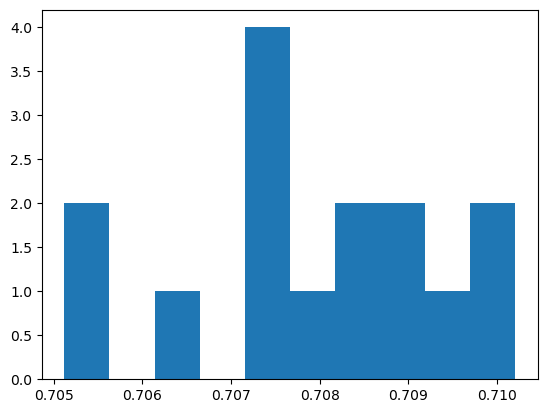

Gradient at the end of step 8 : [       nan 0.03345977 0.15947193 0.10456043 0.03842659 0.30590466
 0.08688791 0.11910323        nan        nan        nan 0.03297114
        nan 0.11608534 0.69036627 0.23659088 0.21101855 0.08985576
 0.28236923        nan 0.31366664 0.58723336 0.41700077 0.09242097
 0.05442641 0.5684723  0.5183296  0.3693618  0.19813621 0.15625651
 0.03172823        nan 0.40132818]
gk : rooOCeanUs1_ORF.15 lambda 0.69036627
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15']

STEP 9 :
p_all tf.Tensor(-93822.57, shape=(), dtype=float32) -p_all tf.Tensor(93822.57, shape=(), dtype=float32)
Gradient at the end of step 8 : [       nan 0.03364137 0.15974432 0.10487823 0.03701919 0.30513284
 0.08711492 0.11955722        nan        nan        nan 0.03410613
        nan 0.11962654 0.6895945  0.23659088 0.20843075 0.09135395
 0.28236

Gradient at the end of step 9 : [       nan 0.03364137 0.15974432 0.10487823 0.03701919 0.30513284
 0.08711492 0.11955724        nan        nan        nan 0.03410613
        nan 0.11962654        nan 0.23659088 0.20843075 0.09135395
 0.28236923        nan 0.31144208 0.5864162  0.41663757 0.09219397
 0.0545172  0.5657937  0.52137136 0.36799982 0.19813621 0.15539391
 0.03172823        nan 0.40123737]
gk : rooOCeanUs1_ORF.22 lambda 0.5864162
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22']

STEP 10 :
Gradient at the end of step 9 : [       nan 0.03364137 0.15974432 0.10483283 0.03815419 0.30127385
 0.08670631 0.11769584        nan        nan        nan 0.03451474
        nan 0.11880931        nan 0.23541048 0.21169955 0.09135395
 0.28264162        nan 0.31253168 0.5851904  0.41536635 0.09246637
 0.0544718  0.56670177 

Gradient at the end of step 10 : [       nan 0.03364137 0.15974432 0.10483283 0.03815419 0.30127385
 0.08670631 0.11769584        nan        nan        nan 0.03451474
        nan 0.11880931        nan 0.23541048 0.21169955 0.09135395
 0.28264165        nan 0.31253168        nan 0.41536635 0.09246637
 0.05447181 0.56670177 0.5217346  0.36886242 0.19686502 0.15643813
 0.03172823        nan 0.40160057]
gk : rooOCeanUs1_ORF.26 lambda 0.56670177
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26']

STEP 11 :
Gradient at the end of step 10 : [       nan 0.03209777 0.15974432 0.10469663 0.03851739 0.30299905
 0.08688791 0.12110084        nan        nan        nan 0.03301654
        nan 0.11976273        nan 0.23554668 0.21160875 0.09017356
 0.28068945        nan 0.31275868        nan 0.41713697 0.0926933

Gradient at the end of step 11 : [       nan 0.03209777 0.15974432 0.10469663 0.03851739 0.30299905
 0.08688791 0.12110084        nan        nan        nan 0.03301654
        nan 0.11976273        nan 0.23554668 0.21160875 0.09017356
 0.28068945        nan 0.31275868        nan 0.41713697 0.09269337
 0.05469881        nan 0.52178    0.36645624 0.19736443 0.15612032
 0.03172823        nan 0.39928517]
gk : rooOCeanUs1_ORF.27 lambda 0.52178
Active set at this step : ['rooOCeanUs1_ORF.1', 'rooOCeanUs1_ORF.20', 'rooOCeanUs1_ORF.13', 'rooOCeanUs1_ORF.32', 'rooOCeanUs1_ORF.11', 'rooOCeanUs1_ORF.10', 'rooOCeanUs1_ORF.9', 'rooOCeanUs1_ORF.15', 'rooOCeanUs1_ORF.22', 'rooOCeanUs1_ORF.26', 'rooOCeanUs1_ORF.27']

STEP 12 :
Gradient at the end of step 11 : [       nan 0.03250637 0.15974432 0.10456043 0.03824499 0.30445185
 0.08688791 0.11828604        nan        nan        nan 0.03315273
        nan 0.11890014        nan 0.23627308 0.20938414 0.09053676
 0.28350425        nan 0.31439307        nan 0

In [426]:
plt.hist([0.708436, 0.707301, 0.70911705, 0.7101612, 0.7051219, 0.70780045, 0.707301, 0.70879924, 0.70562124, 0.70966184, 0.7102066, 0.7071648, 0.70639306, 0.7075734, 0.70857227])

In [428]:
from scipy import stats

# H0: la liste suit une distribution normale
# H1: la liste ne suit pas une distribution normale
stat, p = stats.shapiro([0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798, 0.03228798])

alpha = 0.05
if p > alpha:
    print("La liste suit une distribution normale (p=%.3f)" % (p))
else:
    print("La liste ne suit pas une distribution normale (p=%.3f)" % (p))


La liste suit une distribution normale (p=1.000)
p_all tf.Tensor(-97080.75, shape=(), dtype=float32) -p_all tf.Tensor(97080.75, shape=(), dtype=float32)
p_all tf.Tensor(-97080.75, shape=(), dtype=float32) -p_all tf.Tensor(97080.75, shape=(), dtype=float32)
p_all tf.Tensor(-97080.75, shape=(), dtype=float32) -p_all tf.Tensor(97080.75, shape=(), dtype=float32)
p_all tf.Tensor(-97080.766, shape=(), dtype=float32) -p_all tf.Tensor(97080.766, shape=(), dtype=float32)
p_all tf.Tensor(-97080.76, shape=(), dtype=float32) -p_all tf.Tensor(97080.76, shape=(), dtype=float32)
Gradient at the end of step 12 : [       nan 0.03364137 0.15974432 0.10487823 0.03738239 0.30340764
 0.08711491 0.11946644        nan        nan        nan 0.03233554
        nan 0.11962651        nan 0.23586448 0.20788595 0.09117235
 0.28205147        nan 0.31230468        nan 0.41722775 0.09187617
 0.05488041        nan        nan 0.36745504 0.19722822 0.15530312
 0.03172823        nan 0.40069255]
gk : rooOCeanUs1_ORF.23 la

Clean the script directory

In [21]:
os.system('rm -r rooOceanUs1_genome.fa_temp-orf')

0